In [1]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
from numpy.linalg import inv
import matplotlib . pyplot as plt
import cv2 as cv
import random

In [41]:

# np . random. seed ( 0 )
N = 100
half_n = N// 2
r = 10
s = r/16
t = np . random. uniform(0,2*np.pi,half_n)
n = s*np . random. randn (half_n)
x , y = (r+n)*np.cos(t) ,(r+n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1),y.reshape(half_n,1)))
m, b = -1, 2
x = np.linspace(-12,12 ,half_n)
y = m*x+b+s*np.random.randn(half_n)
X_line = np.hstack((x .reshape(half_n,1),y.reshape(half_n,1)))
X = np.vstack((X_circ,X_line))



In [35]:
def RANSAC_line(Data_set,s,t,e,p):
    No_of_iterations=int(np.log(1-p)/np.log(1-(1-e)**s))

    max_inlinear_count=0
    best_fit_line_coefficient=[]

    for sample in range(0,No_of_iterations+1):
        point1,point2=random.randint(0,len(Data_set)-1),random.randint(0,len(Data_set)-1)
        a = Data_set[point1][1]-Data_set[point2][1]
        b = Data_set[point2][0]-Data_set[point1][0]
        c = Data_set[point1][0]*Data_set[point2][1] - Data_set[point1][1]*Data_set[point2][0]

        inlinear_count=0
        for i in range(0,len(Data_set)):
            distance=abs((a*Data_set[i][0] + b*Data_set[i][1]+c)/(np.sqrt(a**2+b**2)))
            if distance<t:
                inlinear_count+=1
        if inlinear_count > max_inlinear_count:
            max_inlinear_count = inlinear_count
            best_fit_line_coefficient = [a,b,c]
    
    plt.figure(figsize=(15,15))
    for data_point in Data_set:
        plt.scatter(data_point[0],data_point[1])
    x_values=np.arange(-15,15+1)
    y_values=-1*(x_values*best_fit_line_coefficient[0]+best_fit_line_coefficient[2])/best_fit_line_coefficient[1]

    plt.plot(x_values,y_values,color="red")
    plt.show()

    print("Number of Samples =",No_of_iterations)
    print("Inlinear Count =",max_inlinear_count)

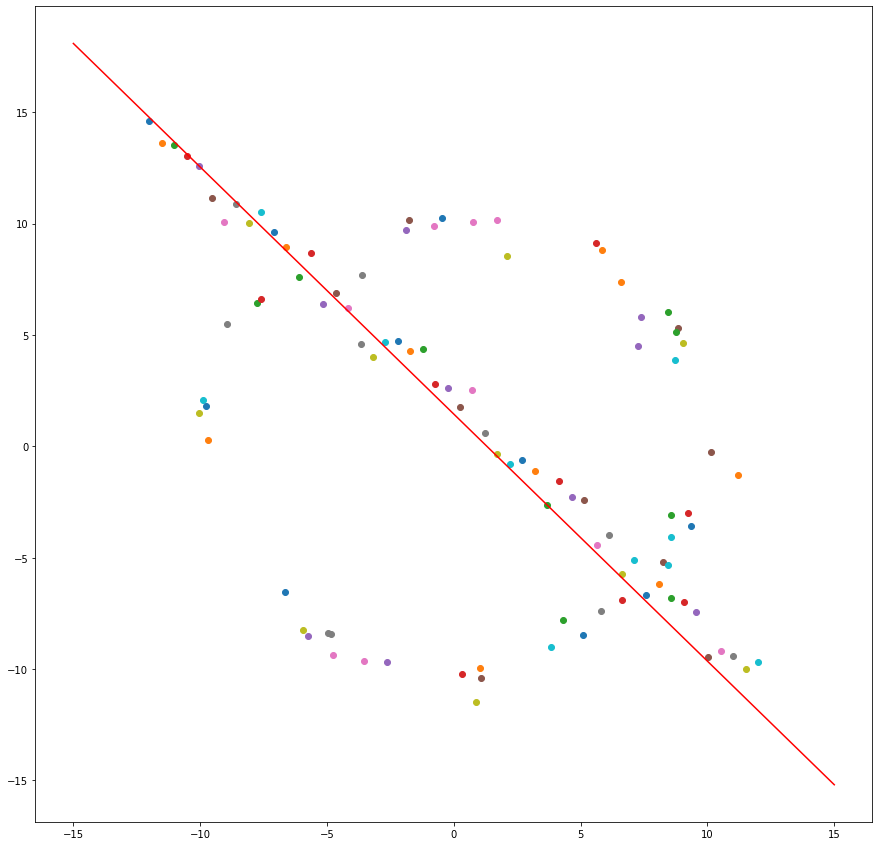

Number of Samples = 6
Inlinear Count = 44


In [36]:
RANSAC_line(X,2,1,0.3,0.99)

In [190]:
def RANSAC_circle(Data_set,No_of_iterations,t):
    max_in_count=0
    best_fit_circle_coeff=[]
    best_sample_points=[]
    
    for sample in range(0,No_of_iterations+1):
        p1,p2,p3=random.randint(0,len(Data_set)-1),random.randint(0,len(Data_set)-1),random.randint(0,len(Data_set)-1)
        x1,x2,x3=Data_set[p1][0],Data_set[p2][0],Data_set[p3][0]
        y1,y2,y3=Data_set[p1][1],Data_set[p2][1],Data_set[p3][1]

        P = np.array([[2*x1 , 2*y1 , 1] , [2*x2 , 2*y2 , 1] , [2*x3 , 2*y3 , 1]])
        if (np.linalg.det(P)==0):
            continue
        K=np.array([[x1**2 + y1**2] , [x2**2 + y2**2] , [x3**2+y3**2]])*(-1)
        answer=np.linalg.inv(P)@ K
        g,f,c=answer[0][0],answer[1][0],answer[2][0]
        radius=np.sqrt(g**2+f**2-c)
        if radius>15:
            continue
        center=[-g,-f]

        in_count=0
        for i in range(0,len(Data_set)):
            d=abs(np.sqrt((Data_set[i][0]-center[0])**2 + (Data_set[i][1]-center[1])**2) - radius)
            if d < t:
                in_count+=1
        if in_count>max_in_count:
            max_in_count=in_count
            best_fit_circle_coeff=[g,f,c]
            best_sample_points=np.array([Data_set[p1],Data_set[p2],Data_set[p3]])
    return(best_fit_circle_coeff,best_sample_points,max_in_count)

In [195]:
s=3
t=0.8
e=0.7
p=0.99
iterations=int(np.log(1-p)/np.log(1-(1-e)**s))

ransac_circle_coeff,ransac_sample,ransac_in_count=RANSAC_circle(X,iterations,t)
F,G,C=ransac_circle_coeff[0],ransac_circle_coeff[1],ransac_circle_coeff[2]
R=np.sqrt(G**2+F**2-C)

In,Out=[],[]
for p in X:
    d=abs(np.sqrt((p[0]+G)**2+(p[1]+F)**2)-R)
    if d<t:
        In.append(p)
    else:
        Out.append(p)
Inliners = np.array(In).T
Outliners = np.array(Out).T
Samp = ransac_sample.T
  
best_circle_coeff,best_sample,best_in_count=RANSAC_circle(X,10000,t)
best_F,best_G,best_C=best_circle_coeff[0],best_circle_coeff[1],best_circle_coeff[2]
best_R=np.sqrt(best_G**2+best_F**2-best_C)
best_sample_T=best_sample.T

print("Number of inlinears for best fitting circle=",best_in_count)
print("Number of Iterations =",iterations)
print("Inlinear Count of RANSAC Estimated circle =",ransac_in_count) 

Number of inlinears for best fitting circle= 44
Number of Iterations = 168
Inlinear Count of RANSAC Estimated circle = 40


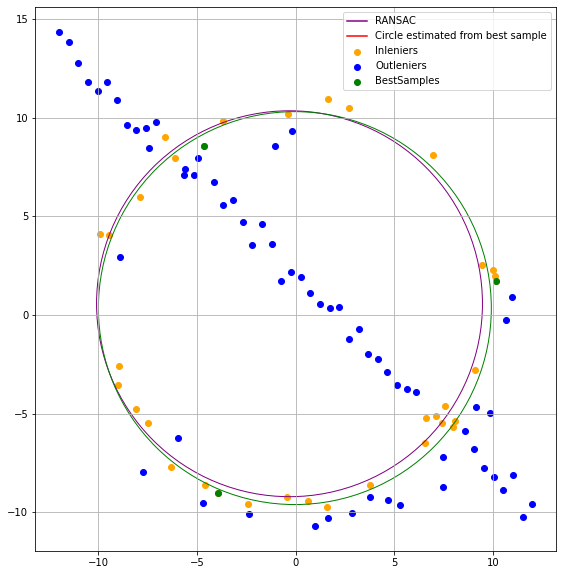

In [196]:
#plotting
figure, axes = plt.subplots( 1, figsize=(10,10) )
axes.grid(True)
ransac_circle = plt.Circle((-G,-F), R, fill=False, color="purple" ,label="RANSAC")
best_fitting_circle = plt.Circle((-best_G,-best_F), best_R, fill=False, color="green" ,label="Best Fitting")

axes.scatter(Inliners[0],Inliners[1], color="orange" , label="Inliners")
axes.scatter(Outliners[0],Outliners[1], color="blue" , label="Outliners")
axes.scatter(best_sample_T[0] ,best_sample_T[1], color="green" , label="Best Samples")
axes.plot(-G,-F,color="purple",label='RANSAC')
axes.plot(-best_G,-best_F,color="red",label='Circle estimated from best sample')
axes.set_aspect( 1 )
axes.add_artist( ransac_circle )
axes.add_artist( best_fitting_circle )

plt.legend()
plt.show()

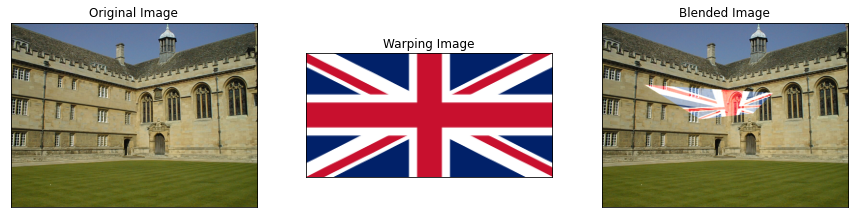

In [2]:
def MouseHandling(event,x,y,f,pram):
    global im_temp,source_points
    if event== cv.EVENT_LBUTTONDOWN:
        cv.circle(im_temp ,(x,y),2,(0,0,255),5,cv.LINE_AA)
        cv.imshow("Image",im_temp)
        if len(source_points)<4:
            source_points = np.append(source_points,[(x,y)],axis=0)

building_img = cv.imread(r'001.jpg')
assert building_img is not None
RGB_build = cv.cvtColor(building_img, cv.COLOR_BGR2RGB)
im_temp = cv.cvtColor(RGB_build, cv.COLOR_RGB2BGR)
h, w = building_img.shape[0] , building_img.shape[1]

flag = cv.imread(r'Flag_of_the_United_Kingdom.svg.png')
assert flag is not None
flag_w,flag_h = flag.shape[1] , flag.shape[0]
points = np.array([[0,0] , [flag_w-1,0] , [flag_w-1,flag_h-1] , [0,flag_h-1] ])

source_points = np.empty((0,2))

cv.namedWindow("Image",1)
cv.setMouseCallback("Image", MouseHandling)
cv.imshow("Image",im_temp)
cv.waitKey(0)

H,S = cv.findHomography(source_points,points)
t_flag = cv.warpPerspective(flag, np.linalg.inv(H), (w, h))
blend = cv.addWeighted(building_img, 1, t_flag, 0.9, 0)

cv.imshow("Image",blend)
cv.waitKey(0)

figure, axes = plt.subplots( 1,3, figsize=(15,10) )
axes[0].imshow(cv.cvtColor(building_img,cv.COLOR_BGR2RGB))
axes[0].set_title("Original Image")

axes[1].imshow(cv.cvtColor(flag,cv.COLOR_BGR2RGB))
axes[1].set_title("Warping Image")

axes[2].imshow(cv.cvtColor(blend,cv.COLOR_BGR2RGB))
axes[2].set_title("Blended Image")
for i in range(3):
    axes [i] . set_xticks ([]) , axes [i] . set_yticks ([])
cv.destroyAllWindows()

In [20]:
building_img = cv.imread(r'Black-Screen-on-Laptop.jng')
assert building_img is not None
RGB_build = cv.cvtColor(building_img, cv.COLOR_BGR2RGB)
im_temp = cv.cvtColor(RGB_build, cv.COLOR_RGB2BGR)
h, w = building_img.shape[0] , building_img.shape[1]

flag = cv.imread(r'lapscren.jpg')
assert flag is not None
flag_w,flag_h = flag.shape[1] , flag.shape[0]
points = np.array([[0,0] , [flag_w-1,0] , [flag_w-1,flag_h-1] , [0,flag_h-1] ])

source_points = np.empty((0,2))

cv.namedWindow("Image",1)
cv.setMouseCallback("Image", MouseHandling)
cv.imshow("Image",im_temp)
cv.waitKey(0)

H,S = cv.findHomography(source_points,points)
t_flag = cv.warpPerspective(flag, np.linalg.inv(H), (w, h))
blend = cv.addWeighted(building_img, 1, t_flag,1, 0)

cv.imshow("Image",blend)
cv.waitKey(0)

figure, axes = plt.subplots( 1,3, figsize=(15,10) )
axes[0].imshow(cv.cvtColor(building_img,cv.COLOR_BGR2RGB))
axes[0].set_title("Original Image")

axes[1].imshow(cv.cvtColor(flag,cv.COLOR_BGR2RGB))
axes[1].set_title("Warping Image")

axes[2].imshow(cv.cvtColor(blend,cv.COLOR_BGR2RGB))
axes[2].set_title("Blended Image")
for i in range(3):
    axes [i] . set_xticks ([]) , axes [i] . set_yticks ([])
cv.destroyAllWindows()

AssertionError: 

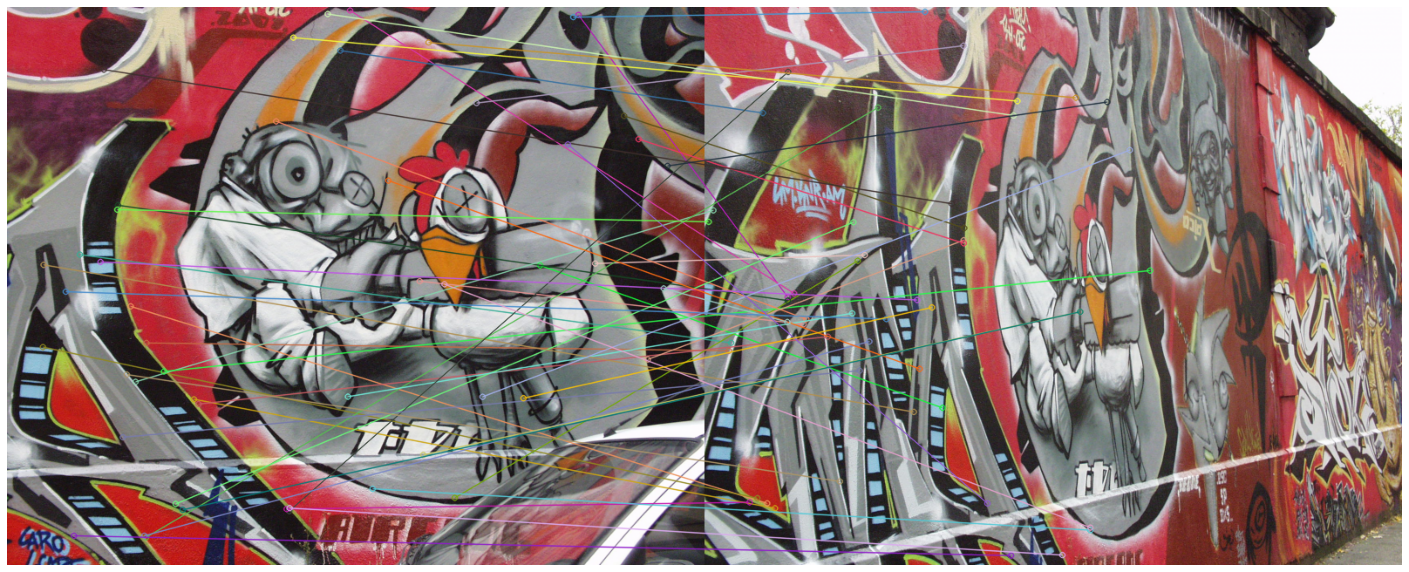

In [5]:
img1 = cv.imread(r'img1.ppm')
assert img1 is not None

img2 = cv.imread(r'img5.ppm')
assert img2 is not None

sift = cv.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None) 
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None) 

bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

matched_img = cv.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
matched_img = cv.cvtColor(matched_img, cv.COLOR_BGR2RGB)

plt.figure(figsize=(25,18))
plt.imshow(matched_img)
plt.axis('off')
plt.show()

In [10]:
import random as rnd
def sift_keypoint(src,dst):
    sift = cv.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(src, None) 
    keypoints_2, descriptors_2 = sift.detectAndCompute(dst, None) 
    bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)
    list_kp1 = []
    list_kp2 = []

    for mat in matches:
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx
        (x1, y1) = keypoints_1[img1_idx].pt
        (x2, y2) = keypoints_2[img2_idx].pt
        list_kp1.append((int(x1+0.5), int(y1+0.5)))
        list_kp2.append((int(x2+0.5), int(y2+0.5)))

    return(list_kp1,list_kp2)

def Homography_by_ransac(src,dst):
    N = 10000
    threshold = 0.3
    max_inlinears = 0
    H=[]
    src_keylist , dst_keylist = sift_keypoint(src,dst)
    src_keylist, dst_keylist = np.array(src_keylist) , np.array(dst_keylist)
    for samp in range(0,N):
        ind1  =rnd.randrange(0,len(src_keylist))
        ind2 = rnd.randrange(0,len(src_keylist))
        ind3 = rnd.randrange(0,len(src_keylist))
        ind4 = rnd.randrange(0,len(src_keylist))
        s_pt1 ,d_pt1 = src_keylist[ind1]  , dst_keylist[ind1]
        s_pt2 ,d_pt2 = src_keylist[ind2]  , dst_keylist[ind2]
        s_pt3 ,d_pt3 = src_keylist[ind3]  , dst_keylist[ind3]
        s_pt4 ,d_pt4 = src_keylist[ind4]  , dst_keylist[ind4]
        colinearity =  bool(np.cross(s_pt1,s_pt2)) and bool(np.cross(s_pt1,s_pt3)) and bool(np.cross(s_pt1,s_pt4))
        colinearity =  colinearity and bool(np.cross(s_pt2,s_pt3)) and bool(np.cross(s_pt2,s_pt4))
        colinearity =  colinearity and bool(np.cross(s_pt3,s_pt4))
        if (not colinearity): continue
        A = np.array([[ -s_pt1[0], -s_pt1[1], -1, 0, 0, 0, d_pt1[0]*s_pt1[0], d_pt1[0]*s_pt1[1], d_pt1[0]],
                      [ 0, 0, 0, -s_pt1[0], -s_pt1[1], -1, d_pt1[1]*s_pt1[0], d_pt1[1]*s_pt1[1], d_pt1[1]],
                      [ -s_pt2[0], -s_pt2[1], -1, 0, 0, 0, d_pt2[0]*s_pt2[0], d_pt2[0]*s_pt2[1], d_pt2[0]],
                      [ 0, 0, 0, -s_pt2[0], -s_pt2[1], -1, d_pt2[1]*s_pt2[0], d_pt2[1]*s_pt2[1], d_pt2[1]],
                      [ -s_pt3[0], -s_pt3[1], -1, 0, 0, 0, d_pt3[0]*s_pt3[0], d_pt3[0]*s_pt3[1], d_pt3[0]],
                      [ 0, 0, 0, -s_pt3[0], -s_pt3[1], -1, d_pt3[1]*s_pt3[0], d_pt3[1]*s_pt3[1], d_pt3[1]],
                      [ -s_pt4[0], -s_pt4[1], -1, 0, 0, 0, d_pt4[0]*s_pt4[0], d_pt4[0]*s_pt4[1], d_pt4[0]],
                      [ 0, 0, 0, -s_pt4[0], -s_pt4[1], -1, d_pt4[1]*s_pt4[0], d_pt4[1]*s_pt4[1], d_pt4[1]],
                      [0, 0, 0, 0, 0, 0, 0, 0, 1]])
        h = np.linalg.inv(A) @ np.array([[0,0,0,0,0,0,0,0,1]]).T
        h = np.reshape(h,(3,3))
        X = np.vstack([src_keylist.T , np.ones( (1, len(src_keylist)) )])
        transformed_keys = h @ X
        z= np.array([transformed_keys[-1]]).T
        transformed_keys = (transformed_keys[:2].T) / z
        inlinears_count = 0
        for  i in range(0 , len(transformed_keys)):
            distance = np.sqrt( (transformed_keys[i][0] - dst_keylist[i][0])**2 + (transformed_keys[i][1] - dst_keylist[i][1])**2 )
            if abs(distance) < threshold:
                inlinears_count += 1
        if inlinears_count > max_inlinears:
            max_inlinears = inlinears_count
            H = h
    return(H)


In [11]:
H = np.identity(3)
for i in range(4):
    src_name = str(i + 1)+'.ppm'
    src_img = cv.imread(r'img'+src_name)
    assert src_img is not None

    dst_name = str(i + 2)+'.ppm'
    dst_img = cv.imread(r'img'+dst_name)
    assert dst_img is not None

    H = np.matmul(Homography_by_ransac(src_img, dst_img), H)
print(H)

[[ 6.23464453e-01  5.65653556e-02  2.21403786e+02]
 [ 2.23198146e-01  1.16245970e+00 -2.73601364e+01]
 [ 4.94360830e-04 -3.78316955e-05  9.93881250e-01]]


In [7]:
im1to2 = cv.warpPerspective(img2,np.linalg.inv(H),(2000,1000))
im1to2=cv.cvtColor(im1to2, cv.COLOR_BGR2RGB)
cv.namedWindow("Transform",1)
cv.imshow("Transform",im1to2)
cv.waitKey(0)
cv.destroyAllWindows()

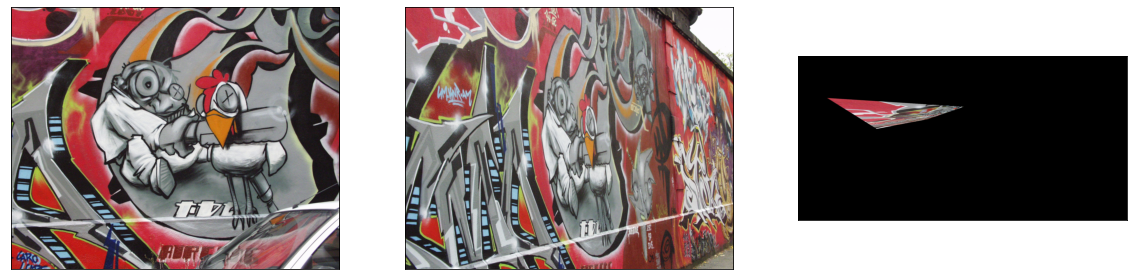

In [8]:
fig, ax = plt.subplots(1,3,figsize =(20,20))
ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[0].set_xticks([]), ax[0].set_yticks([])
ax[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
ax[1].set_xticks([]), ax[1].set_yticks([])
ax[2].imshow(im1to2)
ax[2].set_xticks([]), ax[2].set_yticks([])
plt.show()